# Blood Donor ML 

In [13]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
DATA_PATHS=[Path('blood.csv'),Path('/mnt/data/blood.csv')]
for p in DATA_PATHS:
    if p.exists():
        DATA_FILE=p;break
else:
    raise FileNotFoundError('blood.csv not found')
df=pd.read_csv(DATA_FILE)
df.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,99,1
1,0,13,3250,28,1
2,1,17,4000,36,1
3,2,20,5000,45,1
4,1,24,6000,77,0


**Explanation:** Load the CSV and preview the data.

In [2]:
target_col='Class'
X=df.drop(columns=[target_col])
y=df[target_col].astype(int)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
('train',X_train.shape,'test',X_test.shape)

('train', (598, 4), 'test', (150, 4))

**Explanation:** Split features/label and create train/test sets.

In [3]:
log_reg=Pipeline([('scaler',StandardScaler()),('clf',LogisticRegression(max_iter=500))])
rf=Pipeline([('clf',RandomForestClassifier(n_estimators=300,random_state=42))])
log_reg.fit(X_train,y_train); rf.fit(X_train,y_train)
for name,model in [('LogReg',log_reg),('RF',rf)]:
    preds=model.predict(X_test)
    try:
        proba=model.predict_proba(X_test)[:,1]
    except Exception:
        proba=None
    print(name, {
        'acc':accuracy_score(y_test,preds),
        'prec':precision_score(y_test,preds,zero_division=0),
        'rec':recall_score(y_test,preds,zero_division=0),
        'f1':f1_score(y_test,preds,zero_division=0),
        'roc_auc': roc_auc_score(y_test,proba) if proba is not None else float('nan')
    })

LogReg {'acc': 0.7666666666666667, 'prec': 0.5714285714285714, 'rec': 0.1111111111111111, 'f1': 0.18604651162790697, 'roc_auc': 0.7872807017543859}
RF {'acc': 0.7466666666666667, 'prec': 0.4666666666666667, 'rec': 0.3888888888888889, 'f1': 0.42424242424242425, 'roc_auc': 0.7284356725146199}


**Explanation:** Train two simple models and print key metrics.

In [4]:
import numpy as np
def safe_auc(model):
    try:
        return roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    except Exception:
        return float('nan')
best_model = rf if np.nan_to_num(safe_auc(rf)) >= np.nan_to_num(safe_auc(log_reg)) else log_reg
import joblib, json
from pathlib import Path
Path('artifacts').mkdir(exist_ok=True)
joblib.dump(best_model, 'artifacts/blood_donor_model.joblib')
with open('artifacts/feature_names.json','w') as f: json.dump(list(X.columns), f)
'Artifacts saved.'

'Artifacts saved.'

**Explanation:** Save the chosen model and feature names for reuse.

In [6]:
import pandas as pd, numpy as np
def donor_recommendation(row, predicted_label, proba=None):
    r=row.get('Recency',np.nan); f=row.get('Frequency',np.nan); m=row.get('Monetary',np.nan); t=row.get('Time',np.nan)
    notes=[]
    if pd.notna(r):
        notes.append('More recent donor' if r<=6 else 'Long time since last donation')
    if pd.notna(f):
        notes.append('High-frequency donor' if f>=4 else 'New/low-frequency donor')
    if pd.notna(m) and m>=3000:
        notes.append('Substantial cumulative donation')
    if pd.notna(t):
        notes.append('Long-tenured donor' if t>=24 else 'New donor')
    action='Schedule next donation window' if int(predicted_label)==1 else 'Send re-engagement nudge'
    if proba is not None: notes.append(f'Confidence ~ {proba:.2f}')
    return action + ' | ' + ' '.join(notes)

def predict_and_recommend(input_df, model=best_model):
    preds=model.predict(input_df)
    try:
        proba=model.predict_proba(input_df)[:,1]
    except Exception:
        proba=[None]*len(input_df)
    recos=[]
    for i,(idx,row) in enumerate(input_df.iterrows()):
        recos.append(donor_recommendation(row, preds[i], (proba[i] if proba[i] is not None else None)))
    out=input_df.copy(); out['predicted_donate']=preds
    if proba[0] is not None: out['prob_donate']=proba
    out['recommendation']=recos; return out

predict_and_recommend(X_test.head(10))

,Recency,Frequency,Monetary,Time,predicted_donate,prob_donate,recommendation
514,4,16,4000,38,1,0.596373,Schedule next donation window | More recent do...
417,16,1,250,16,0,0.104767,Send re-engagement nudge | Long time since las...
497,38,1,250,38,0,0.010107,Send re-engagement nudge | Long time since las...
91,4,2,500,4,0,0.335601,Send re-engagement nudge | More recent donor N...
312,12,9,2250,60,0,0.149379,Send re-engagement nudge | Long time since las...
5,4,4,1000,4,0,0.396764,Send re-engagement nudge | More recent donor H...
337,11,7,1750,64,0,0.118520,Send re-engagement nudge | Long time since las...
177,4,5,1250,33,0,0.279354,Send re-engagement nudge | More recent donor H...
468,22,1,250,22,0,0.056757,Send re-engagement nudge | Long time since las...
249,11,2,500,11,0,0.188617,Send re-engagement nudge | Long time since las...


**Explanation:** Turn predictions into clear outreach suggestions for each donor.

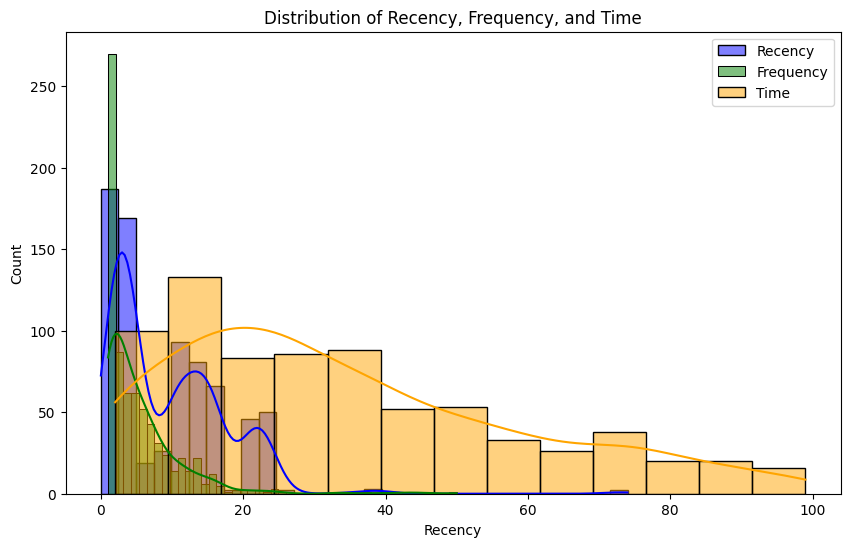

In [10]:


# Data distribution for Recency, Frequency, Time
plt.figure(figsize=(10, 6))
sns.histplot(df['Recency'], kde=True, color='blue', label='Recency')
sns.histplot(df['Frequency'], kde=True, color='green', label='Frequency')
sns.histplot(df['Time'], kde=True, color='orange', label='Time')
plt.title('Distribution of Recency, Frequency, and Time')
plt.legend()

plt.show()

In [ ]:
#Recency: Months since last donation (most donors donated recently).
#Frequency: Number of past donations (most donors donated less than 10 times).
#Time: How long they have been donating (peaks in early months).

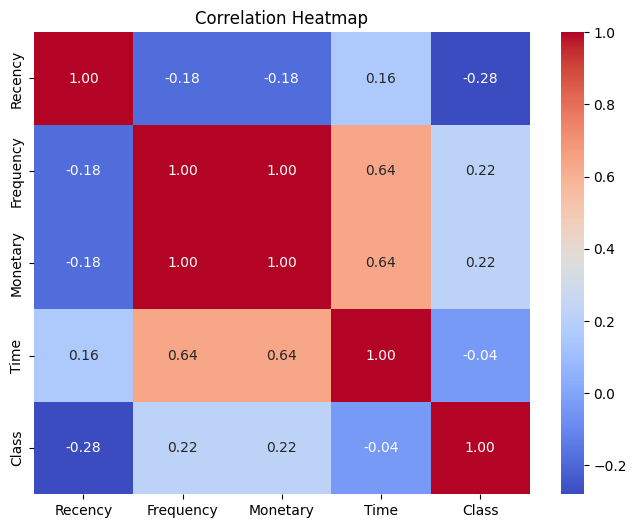

In [12]:
plt.figure(figsize=(8, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
#Frequency & Monetary are highly correlated (logical as more donations = more blood donated).
#Recency negatively correlates with donation likelihood (recent donors likely to donate again).

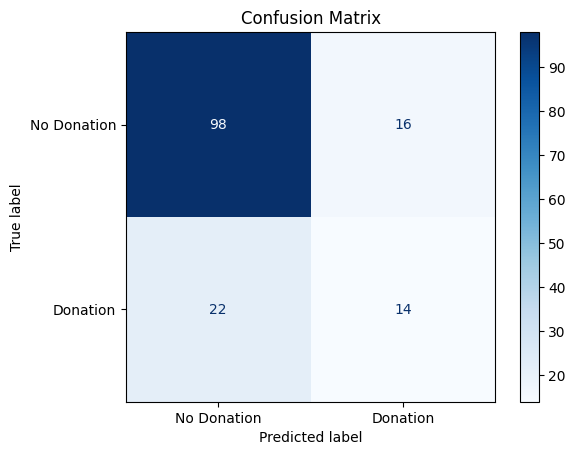

In [15]:

# Example: Assuming y_test and y_pred exist
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Donation', 'Donation'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()






In [ ]:
#True Positives (bottom-right): Donors correctly predicted as donors.
#True Negatives (top-left): Non-donors correctly identified.
#False Positives/Negatives: Model misclassifications.